# Exploring and Classifying Genres in Music

#### Authors (alphabetically): Aditya Kanthale, Amanuel Odicho, Vivek Patel<br/>

The code for our project can be found here: [spotify-data-science](https://github.com/stoic-devv/spotify-data-science)
Dataset can be downloaded from here directly: [data](https://github.com/stoic-devv/spotify-data-science/blob/main/data/final-data.csv)

Insert intro from the report

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns 
from collections import defaultdict
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Extraction

For brevity, we have not included our code for data extraction in this notebook.
Here are some notebooks from our repository:
1. For extracting data from RateYourMusic: [album-data-rym.ipynb](https://github.com/stoic-devv/spotify-data-science/blob/main/code/album-data-rym.ipynb)
2. Scraper code and library used: [rym_charts.py](https://github.com/stoic-devv/spotify-data-science/blob/main/code/rym_charts.py), [rymscraper](https://github.com/stoic-devv/spotify-data-science/blob/main/code/lib/rymscraper/)
3. Extracting song data from Spotify: [song-data-extraction.ipynb](https://github.com/stoic-devv/spotify-data-science/blob/main/code/song-data-extraction.ipynb)
4. Merging RYM and Spotify data: [merge-data.ipynb](https://github.com/stoic-devv/spotify-data-science/blob/main/code/merge-data.ipynb)


## Data Cleaning

In [3]:
df = pd.read_csv('../data/final-data.csv', sep='~')
df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,...,album,date,rym rating,ratings,reviews,name,popularity,rym_genres,sp_genres,genre
0,0,0,6970,0.526,0.235,7,-14.074,0,0.0991,0.907,...,"""Al final de este viaje...""",1978-04-27,3.92,1673.0,33.0,Ojalá,68,Nueva trova,"['cantautor', 'latin alternative', 'nueva canc...",NF
1,1,1,6974,0.571,0.134,0,-14.650,1,0.0704,0.895,...,"""Al final de este viaje...""",1978-04-27,3.92,1673.0,33.0,Óleo de Mujer Con Sombrero,62,Nueva trova,"['cantautor', 'latin alternative', 'nueva canc...",NF
2,2,2,6968,0.562,0.213,8,-12.273,1,0.0841,0.876,...,"""Al final de este viaje...""",1978-04-27,3.92,1673.0,33.0,Canción Del Elegido,55,Nueva trova,"['cantautor', 'latin alternative', 'nueva canc...",NF
3,3,3,6977,0.504,0.261,9,-12.577,1,0.0620,0.794,...,"""Al final de este viaje...""",1978-04-27,3.92,1673.0,33.0,Al Final de Este Viaje en la Vida,52,Nueva trova,"['cantautor', 'latin alternative', 'nueva canc...",NF
4,4,4,6969,0.682,0.236,6,-11.647,0,0.2490,0.844,...,"""Al final de este viaje...""",1978-04-27,3.92,1673.0,33.0,"La Familia, la Propiedad Privada y el Amor",50,Nueva trova,"['cantautor', 'latin alternative', 'nueva canc...",NF


In [4]:
# Columns and their (sort-of) description
drop_cols = ['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0']
audio_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','type']
meta_data_features = ['id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature', 'name', 'album', 'date']
user_rating_features = ['rym rating', 'ratings', 'reviews']
labels = ['popularity', 'rym_genres', 'sp_genres'] # depending on problem statement

In [5]:
df = df.drop(drop_cols, axis=1)

In [10]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,rym rating,ratings,reviews,popularity
count,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7.252000e+03,7252.000000,7252.000000,6972.00000,6972.000000,7252.000000
mean,0.453320,0.521675,5.230971,-12.092938,0.628378,0.078403,0.416099,0.288986,0.187424,0.423436,116.587878,3.070066e+05,3.841975,3.890232,7550.44148,132.534423,35.110866
std,0.188403,0.290922,3.516420,6.450656,0.483271,0.103382,0.376112,0.368500,0.153149,0.269500,29.705730,2.103129e+05,0.498917,0.103352,9199.56536,174.816432,19.173895
min,0.000000,0.000020,0.000000,-45.243000,0.000000,0.000000,0.000000,0.000000,0.015300,0.000000,0.000000,3.109600e+04,0.000000,3.650000,20.00000,1.000000,0.000000
25%,0.311000,0.276000,2.000000,-15.054250,0.000000,0.035400,0.029075,0.000047,0.095700,0.188000,94.005250,1.937262e+05,4.000000,3.820000,1295.00000,19.000000,22.000000
50%,0.450000,0.533500,5.000000,-10.552500,1.000000,0.044200,0.330000,0.024450,0.125000,0.402000,114.142000,2.559330e+05,4.000000,3.870000,4554.00000,76.000000,36.000000
75%,0.585000,0.773000,8.000000,-7.461500,1.000000,0.070400,0.815000,0.699000,0.228000,0.641000,135.107750,3.505030e+05,4.000000,3.940000,10074.00000,169.000000,49.000000
max,0.967000,1.000000,11.000000,3.744000,1.000000,0.962000,0.996000,1.000000,0.984000,0.984000,222.605000,3.682333e+06,5.000000,4.410000,74911.00000,1559.000000,87.000000


We have handled most of the `NaN` values while data-extraction itself. Due to abundance of data we skipped whichever song had missing values. 
Ratings has some missing values of about 4%. We choose to handle this later once we start building the model as we need to evaluate our assumptions of whether approximating/dropping yeilds better results

In [6]:
# remove encoding 
# eg: '['classic j-rock', 'j-rock']' -> ['classic j-rock', 'j-rock'] (str -> List[str])
def genre_to_list(s):
    return list(map(lambda x: x.strip(' ').strip('\''), s.strip('[').strip(']').split(',')))
from collections import defaultdict
df['sp_genres'] = df['sp_genres'].apply(genre_to_list)

## EDA 1

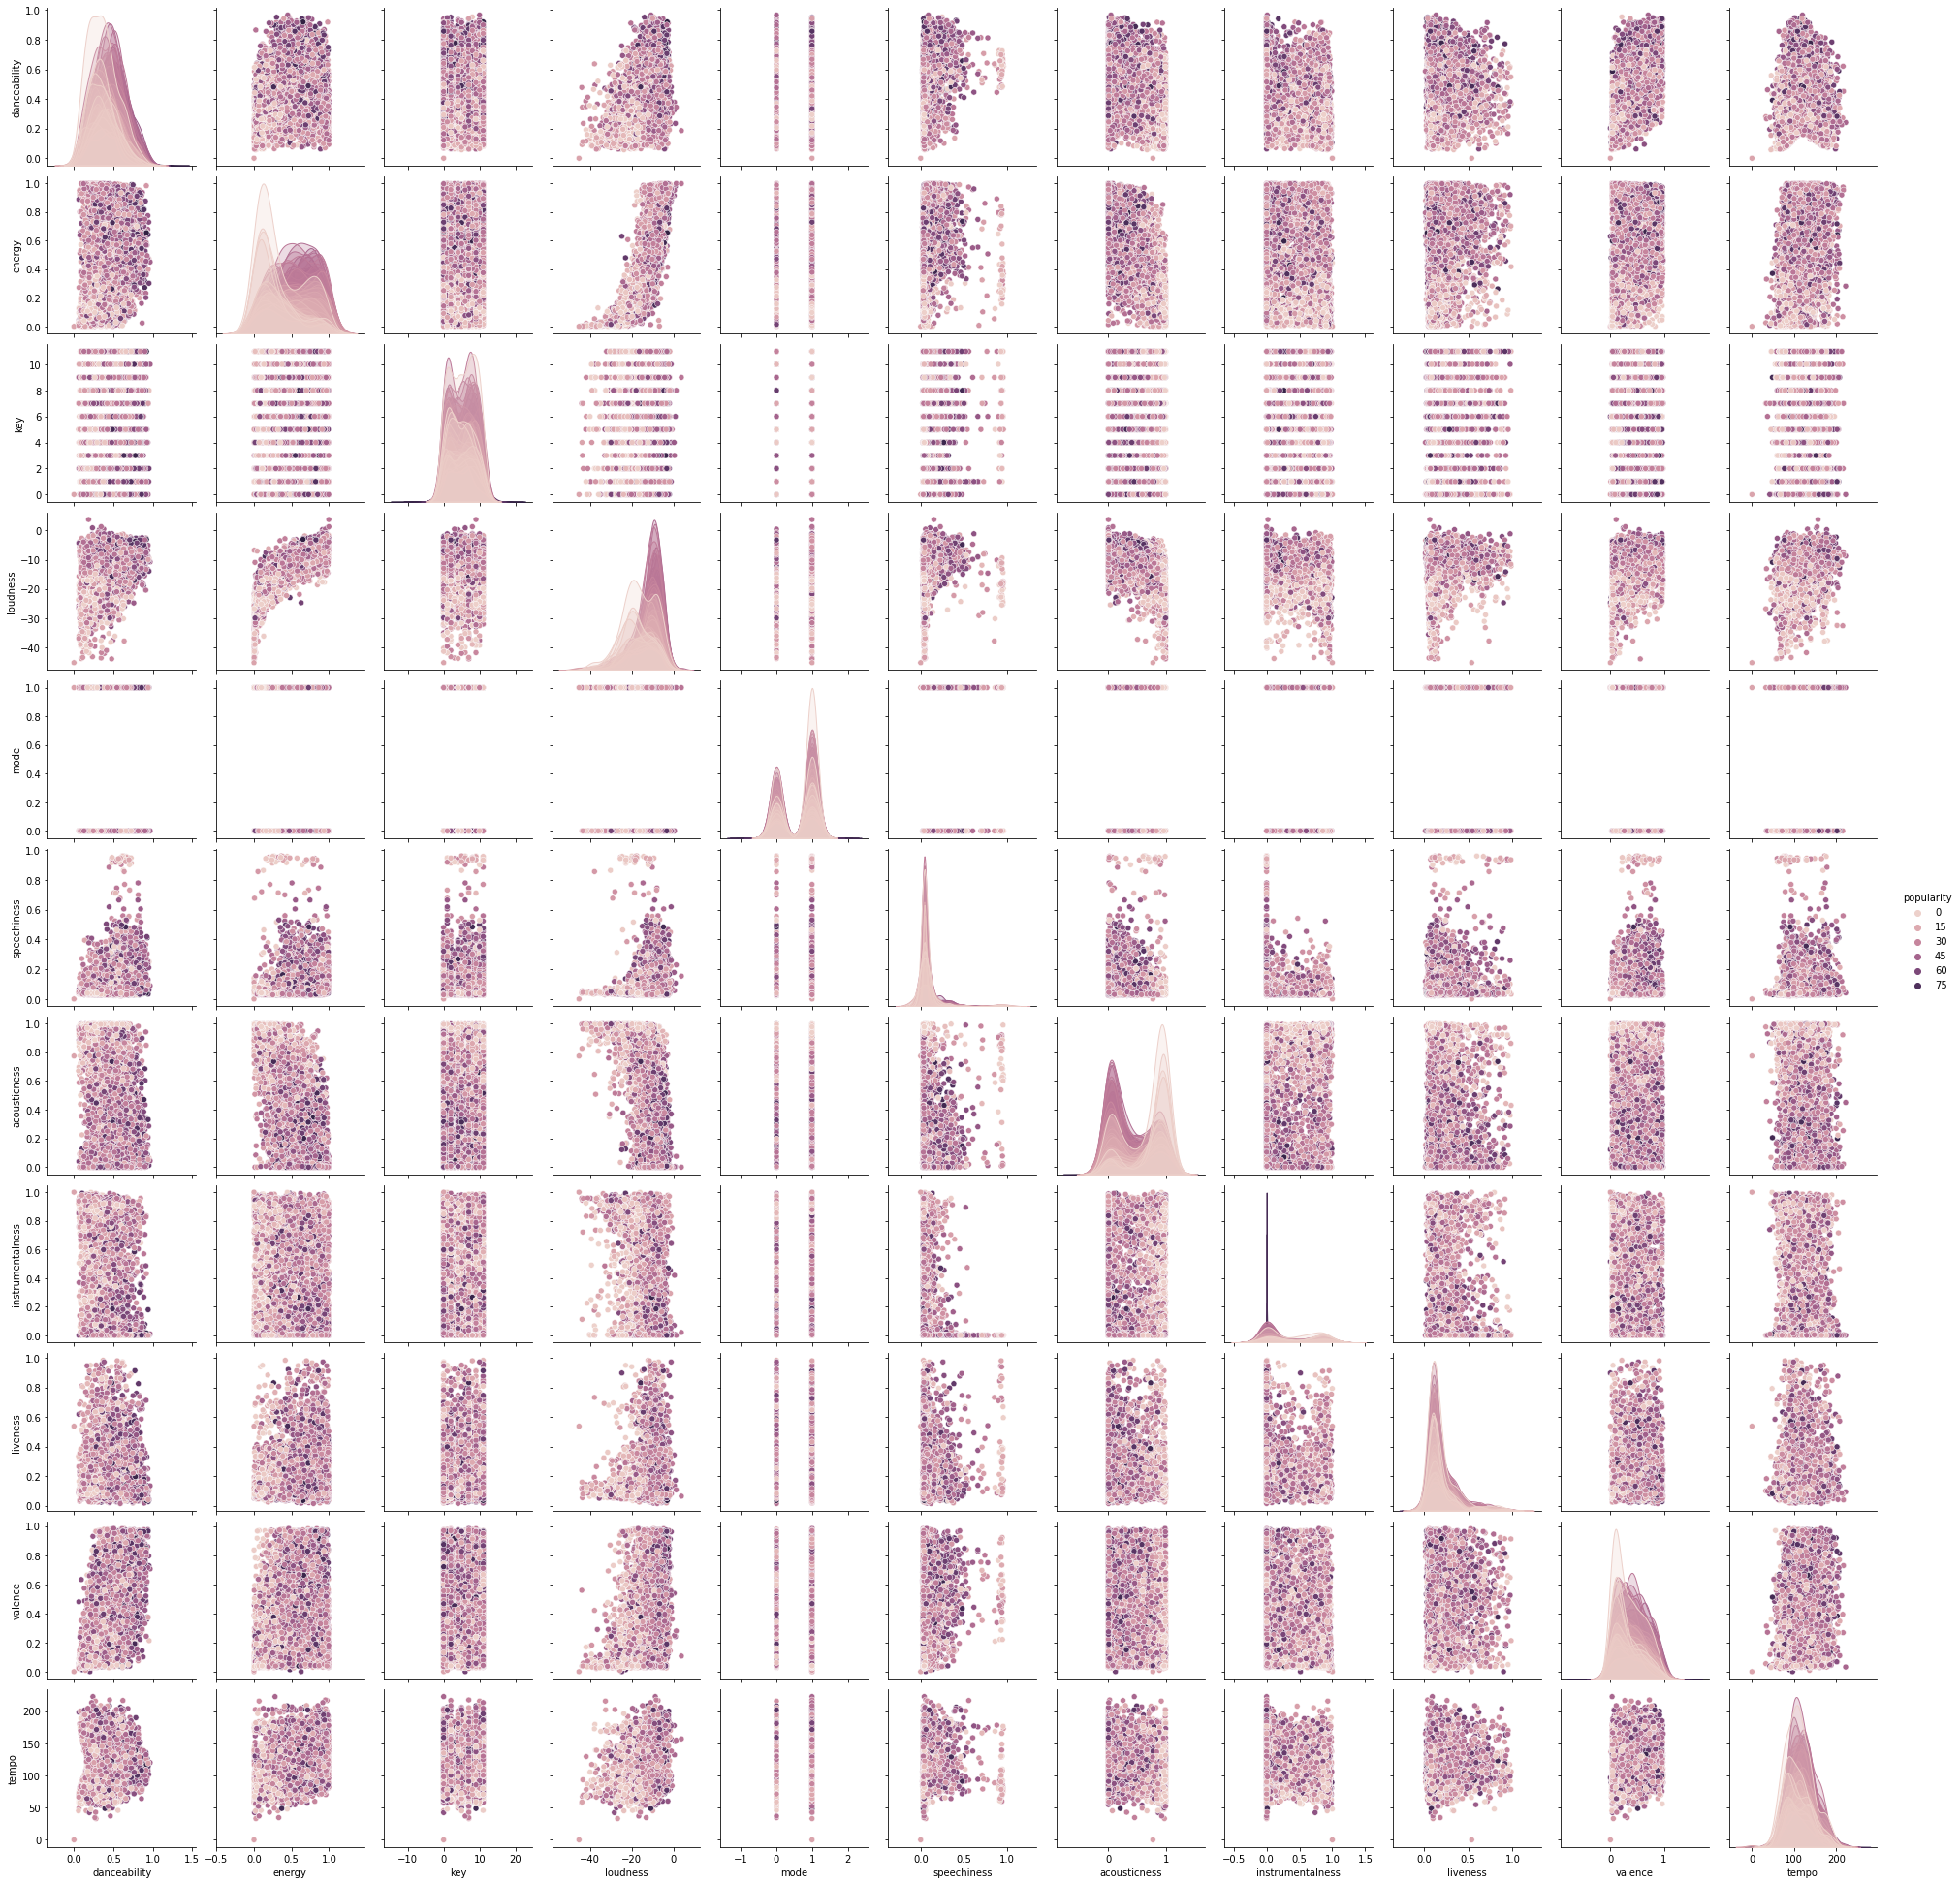

In [8]:
# plotting pair plots to analyze the relation of audio features with popularity
audio_features.append('popularity')
sn_pp = sns.pairplot(df[audio_features],hue='popularity')
sn_pp.savefig("../img/pairplot.png")

Conclusions:

Most liked songs are:
1. Are louder
2. Have higher tempo
3. Uniformly distributed over keys
4. Are not live
5. Are nor instrumental

### KNN for approximating genres
This also shows the correlation of the audio features with 

In [9]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=RANDOM_STATE)
    kmeans.fit(Xc)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

NameError: name 'KMeans' is not defined

In [ ]:
# Aditya
# Identifying top genres, mapping etc

## EDA 2

In [ ]:
# Amanuel
# bar plots, corr-mat, etc

## Model & Analysis

In [ ]:
# Vivek

## Conclusions and Future work

In [ ]:
# Amanuel can start
# We can pitch in later